## SVM-SMO

SVM-SMO 实现。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
def loadData(file, names):
    return pd.read_csv(file, delimiter='\t', names = names)
    

In [220]:
class SVM(object):
    '''
        Using SMO to implement SVM.
    '''
    def __init__(self, data, labels, C = 10, toler = 0.001):
        self.X, self.y = np.mat(data), np.mat(labels)
        self.C, self.toler = C, toler
        self.m, self.n = data.shape
        self.alphas = np.mat(np.zeros((self.m, 1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m, 2)))
        return
    
    def calcEk(self, k):
        '''
            计算误差；将只有一个元素的矩阵转换成 scalar 可以用:
            1. np.squeeze(np.asarray(y[0]))[0]
            2. y[0].A[0][0]
            3. 最简单的方法直接用 float, int 转换函数就可以了。
        '''
        fk = float(np.multiply(self.alphas, self.y).T * self.X * self.X[k].T + self.b)
        Ek = fk - float(self.y[k])
        return Ek
    
    def selectJrand(self, i):
        '''
            从样本中随机选择一个不等于 i 的样本。
        '''
        j = i
        while (j == i):
            j = int(np.random.uniform(0, self.m))
        return j
    
    def selectJ(self, i, Ei):
        '''
            根据样本 i 使用启发式搜索第二个样本 j。第二个样本确保有最大更新步长。
            我是从缓存的误差来选择具有最大更新步长的 j。如果没有满足的缓存的误差则直接随机选择一个。
        '''
        j = -1; maxDeltaE = 0; Ej = 0
        self.eCache[i] = [1, Ei]
        
        cachedList = np.nonzero(self.eCache[:, 0].A)[0]
        if len(cachedList) > 1:
            for k in cachedList:
                if k == i: continue
                Ek = self.calcEk(k)
                deltaE = abs(Ei - Ek)
                if (deltaE > maxDeltaE):
                    j, Ej, maxDeltaE = k, Ek, deltaE
        else:
            j = self.selectJrand(i)
            Ej = self.calcEk(j)
        return j, Ej  
    
    def clipAlpha(self, aj, H, L):
        if aj > H:
            return H
        elif aj < L:
            return L
        return aj
    
    def updateEk(self, j):
        Ej = self.calcEk(j)
        self.eCache[j] = [1, Ej]
        return

    def examineExample(self, i, printLog):
        '''
            根据样本 i 来搜索样本 j。然后优化 alpha_i 和  alpha_j。
            如果能够进行更新则返回 1；否则返回 0；
            j 是 alpha_2
            i 是 alpha_1
        '''
        Ei = self.calcEk(i)
        si = Ei * self.y[i] 
        
        # 选择非边界上的样本。
        if ((si < -self.toler and self.alphas[i] < self.C) or (si > self.toler and self.alphas[i] < 0)):
            j, Ej = self.selectJ(i, Ei)
            ai_old, aj_old = self.alphas[i].copy(), self.alphas[j].copy()
            yi, yj = self.y[i], self.y[j]
            if (yi != yj):
                L = max(0, self.alphas[j] - self.alphas[i])
                H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
            else:
                L = max(0, self.alphas[j] + self.alphas[i] - self.C)
                H = min(self.C, self.alphas[j] + self.alphas[i])
            if L == H: 
                if printLog : print('L == H')
                return 0
            
            eta = 2.0 * self.X[i] * self.X[j].T - self.X[i] * self.X[i].T - self.X[j] * self.X[j].T
            if (eta >= 0):
                if printLog : print('Eta >= 0')
                return 0
            
            self.alphas[j] -= self.y[j] * (Ei - Ej) / eta
            self.alphas[j] = self.clipAlpha(self.alphas[j], H, L)
            self.updateEk(j)
            
            if (abs(self.alphas[j] - aj_old) < 0.00001):
                if printLog : print('j not moving enough')
                return 0
            
            self.alphas[i] += self.y[j] * self.y[i] * (aj_old - self.alphas[j])
            self.updateEk(i)
            
            b1 = self.b - Ei \
                - self.y[i] * (self.alphas[i] - ai_old) * self.X[i] * self.X[i].T \
                - self.y[j] * (self.alphas[j] - aj_old) * self.X[i] * self.X[j].T
            
            b2 = self.b - Ej \
                - self.y[i] * (self.alphas[i] - ai_old) * self.X[i] * self.X[j].T \
                - self.y[j] * (self.alphas[j] - aj_old) * self.X[j] * self.X[j].T
            if (self.alphas[i] > 0) and (self.alphas[i] < self.C): self.b = b1
            elif (self.alphas[j] > 0) and (self.alphas[j] < self.C): self.b = b2
            else: self.b = (b1 + b2) / 2.0
            return 1
        else:
            return 0
        
        pass
        return 1
     
    def smo(self, maxIters = 30, printLog = False):
        '''
            SMO 外循环
        '''
        iters = 0
        examineAll = True
        numChanged = 0
        while ((numChanged > 0 or examineAll) and iters < maxIters):
            numChanged = 0
            iters += 1
            if (examineAll): # 遍历所有样本
                for i in range(self.m):
                    numChanged += self.examineExample(i, printLog)
                    if printLog : 
                        print('Examine All, iter: {0}, i: {1}, pairs changed {2}'.format(iters, i, numChanged))
            else: # 遍历所有非边界上的值，即 0 < alpha < c
                nonBoundIds = np.nonzero((self.alphas.A != 0) * (self.alphas.A != self.C))[0]
                for i in nonBoundIds:
                    numChanged += self.examineExample(i, printLog)
                    if printLog :
                        print('Non bound, iter: {0}, i: {1}, pairs changed {2}'.format(iters, i, numChanged))
            if examineAll: 
                examineAll = False
            elif numChanged == 0: # 如非边界值对应的样本都遍历过了，还是没有更新那么就遍历所有的样本来搜索。
                examineAll = True
                
        return self.b, self.alphas
    
    def calcWs(self):
        return self.X.T * np.multiply(self.alphas, self.y)
    

In [239]:
def plotSVM(X, y, results):
    m = len(results)
    cols = 3
    rows = int(m/3)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=False, figsize=(10 * rows, 5 * cols))
    
    for i in range(rows):
        for j in range(cols):
            ax = axes[i, j]
            # 画出正负样本，和支持向量
            alphas, ws, b = results[i * cols + j]
            positives = X[np.nonzero(y == 1)[0], :]
            negatives = X[np.nonzero(y != 1)[0], :]
            supportVectors = X[np.nonzero(alphas > 0)[0], :]
            
            ax.scatter(positives[:, 0], positives[:, 1], marker='+')
            ax.scatter(negatives[:, 0], negatives[:, 1], c='g')
            ax.scatter(supportVectors[:, 0], supportVectors[:, 1], s=100, facecolors='none', edgecolors='r')
            
            # 画出超平面
            x0 = np.arange(0, 8, 0.1)
            x1 = -(float(ws[0]) * x0 + float(b)) / float(ws[1])
            ax.plot(x0, x1)

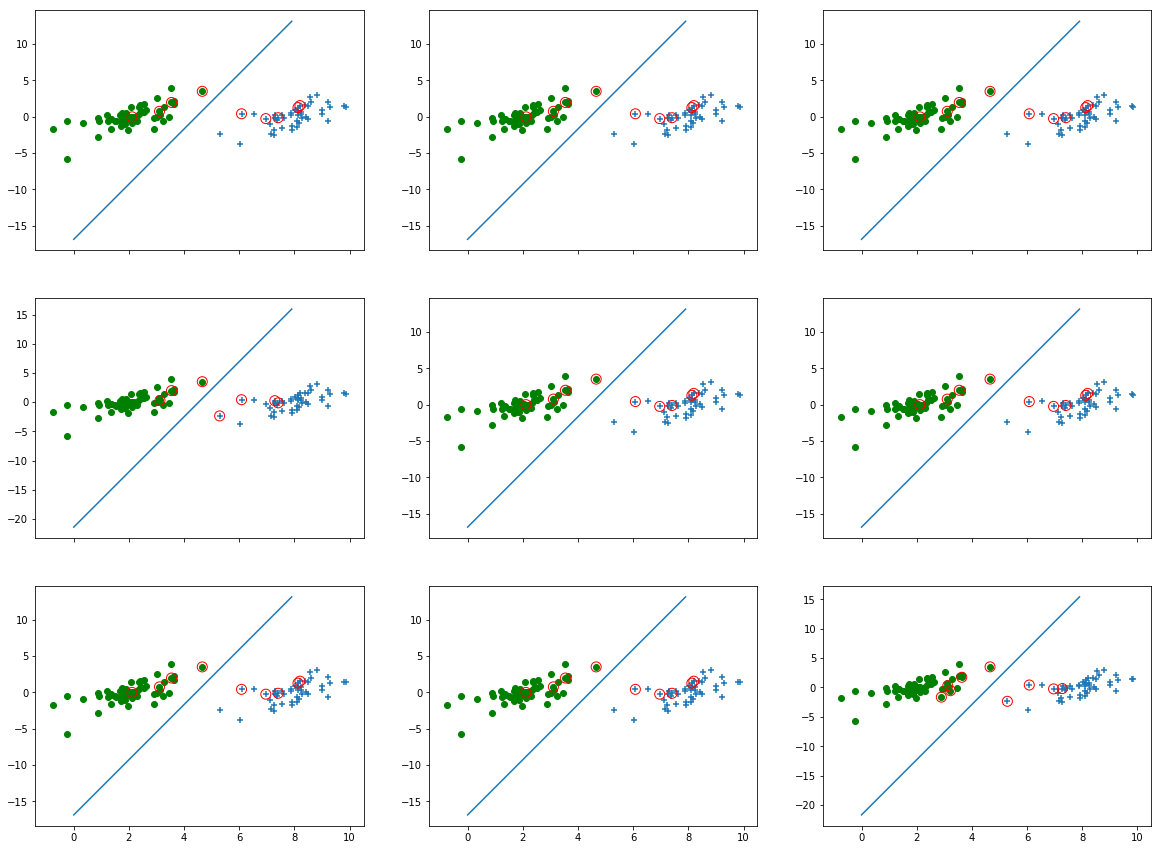

In [246]:
df = loadData('testSet.txt', names=['x1', 'x2', 'label'])
m, n = df.values.shape
X, y = df.values[:, 0:-1], df.values[:, -1:m]

hyperParameters = [
    (0.2, 0.0001, 40),
    (0.4, 0.0001, 40),
    (0.6, 0.0001, 40),
    (0.8, 0.0001, 40),
    (1.0, 0.0001, 40),
    (1.2, 0.0001, 40),
    (1.6, 0.0001, 40),
    (2.0, 0.0001, 40),
    (4.0, 0.0001, 40)
]

results = []

for params in hyperParameters:
    C, toler, iters = params
    svm = SVM(X, y, C, toler)
    b, alphas = svm.smo(iters)
    ws = svm.calcWs()
    results.append((alphas, ws, b))

plotSVM(X, y, results)

从上面来看，我们可以求得的非 0 的支持向量确实很少。

### 松驰变量

1. 松弛变量的值实际上标示出了对应的点到底离群有多远，值越大，点就越远。
2. 惩罚因子C决定了你有多重视离群点带来的损失，显然当所有离群点的松弛变量的和一定时，你定的C越大，对目标函数的损失也越大，此时就暗示着你非常不愿意放弃这些离群点，最极端的情况是你把C定为无限大，这样只要稍有一个点离群，目标函数的值马上变成无限大，马上让问题变成无解，这就退化成了硬间隔问题。

只是上面的样本不太好说明 C 对离群点的影响。C 越大越说明你不愿意离群点，如果 C 定为无线大，那么就会变成硬间隔问题，可能无法优化了。

---------------------

本文来自 qll125596718 的CSDN 博客 ，全文地址请点击：https://blog.csdn.net/qll125596718/article/details/6910921?utm_source=copy 